### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix , accuracy_score , precision_score , recall_score , f1_score

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import mutual_info_regression, SelectPercentile, chi2, f_classif, SelectKBest

from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler,MinMaxScaler

from sklearn.experimental import enable_halving_search_cv

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split

from sklearn.utils import shuffle

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

from xgboost import XGBClassifier

from scipy.stats import chi2_contingency

### Import Dataset

In [2]:
# import the csv
model_train = pd.read_csv('dataset_B_05_2020.csv')

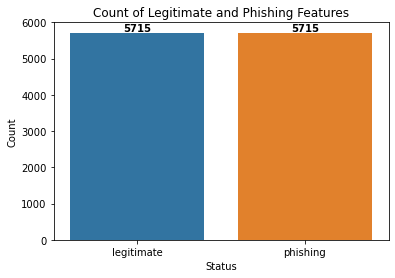

In [4]:
status_count = model_train['status'].value_counts()

# Create a bar plot using Seaborn
sns.countplot(x='status', data=model_train)

# Set the title and labels
plt.title('Count of Legitimate and Phishing Features')
plt.xlabel('Status')
plt.ylabel('Count')

# Add the total count of each value as text on the plot
plt.text(0, status_count[0], status_count[0], ha='center', va='bottom', fontweight='bold')
plt.text(1, status_count[1], status_count[1], ha='center', va='bottom', fontweight='bold')

# Show the plot
plt.show()

## Data Analyze

### Length of URL and Hostname | 1 - 2

In [3]:
grouped_length = model_train.groupby("status")[["length_url", "length_hostname"]].mean().round()

#### Table

In [4]:
grouped_length

,length_url,length_hostname
status,,
legitimate,47.0,19.0
phishing,75.0,24.0


#### Graph

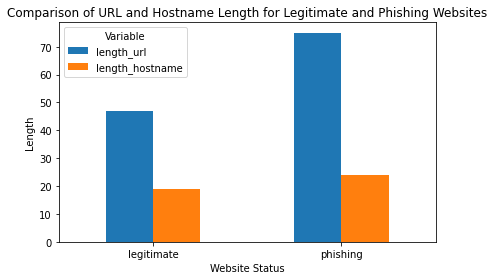

In [5]:
grouped_length.plot(kind="bar")
plt.xticks(rotation=0)
plt.title("Comparison of URL and Hostname Length for Legitimate and Phishing Websites")
plt.xlabel("Website Status")
plt.ylabel("Length")
plt.legend(title="Variable", loc="upper left")
plt.tight_layout()
plt.show()

#### Description

Legitimate websites contains in avarege a smaller url and hostname length than phishing website.

It's possible verify that phishing website have an high average in url length.

This is a high indicator that websites with a url length big are suspisious of being phishing

### Average of websites with IP address present on the URL | 3

In [6]:
contains_ip = model_train[model_train['ip'] == 1]

In [7]:
# Calculate the percentage of each status category
contains_ip_percentages = (contains_ip['status'].value_counts(normalize=True) * 100).round()

In [8]:
df_contains_ip = pd.DataFrame({'Status': contains_ip_percentages.index, 'Percentage': contains_ip_percentages.values})

#### Table

In [22]:
df_contains_ip

,Status,Percentage
0,phishing,88.0
1,legitimate,12.0


#### Graph

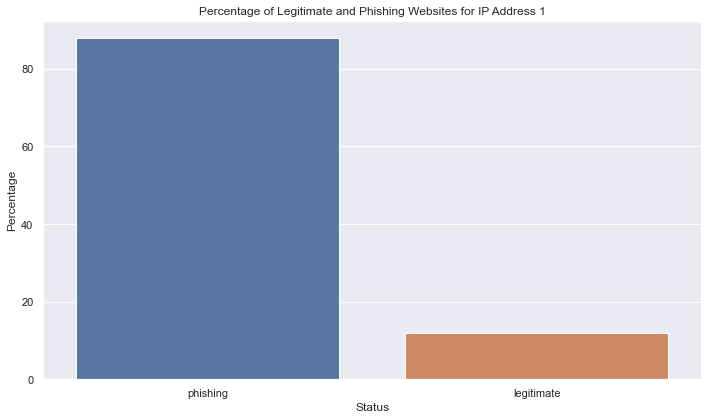

In [23]:
# Create the bar plot using seaborn
sns.barplot(x = contains_ip_percentages.index, y = contains_ip_percentages.values)

# Add axis labels and title
plt.xlabel('Status')
plt.ylabel('Percentage')
plt.title('Percentage of Legitimate and Phishing Websites for IP Address 1')
plt.tight_layout()
plt.show()

#### Description

around 88% of the websites that contains IP address on the URL are labeled as phishing.

this is a high indicator that websites that contains IP address on is URL have a high chance of being phishing.

### Special Characters | 4 - 20

In [24]:
model_train['total_special_chars'] = model_train[['nb_dots', 'nb_hyphens', 'nb_at', 'nb_qm', 'nb_and', 'nb_or', 'nb_eq', 
                                                  'nb_underscore', 'nb_tilde', 'nb_percent', 'nb_slash', 'nb_star', 
                                                  'nb_colon', 'nb_comma', 'nb_semicolumn', 'nb_dollar', 'nb_space']].sum(axis=1)

In [25]:
sp_legitimate_mean = model_train[model_train['status'] == 'legitimate']['total_special_chars'].mean() 
sp_phishing_mean = model_train[model_train['status'] == 'phishing']['total_special_chars'].mean()

In [26]:
sp_dict = {'status': ['legitimate', 'phishing'], 'mean_total_special_chars': [sp_legitimate_mean, sp_phishing_mean]}
sp_mean_df = pd.DataFrame(sp_dict)

#### Table

In [27]:
sp_mean_df

,status,mean_total_special_chars
0,legitimate,8.765879
1,phishing,11.175853


#### Graph

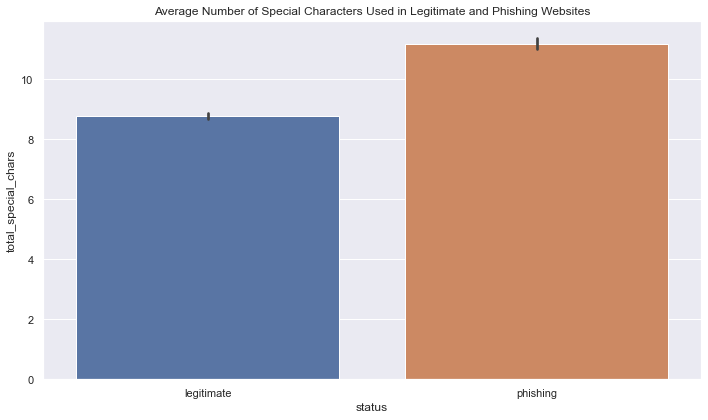

In [28]:
sns.barplot(x='status', y='total_special_chars', data=model_train)
plt.title('Average Number of Special Characters Used in Legitimate and Phishing Websites')
plt.tight_layout()
plt.show()

#### Description

Phishing websites contains in average a high use of special characters than legitimate websites

### Common Terms | 21 -24

In [29]:
model_train['sum_common_terms'] = model_train['nb_www'] + model_train['nb_com'] + model_train['nb_dslash'] + model_train['http_in_path']

In [30]:
ct_unique = model_train["sum_common_terms"].unique()

In [31]:
ct_dict = {}
for value in ct_unique:
    ct_df = model_train[model_train["sum_common_terms"] == value]
    ct_dict[value] = {"legitimate": ct_df[ct_df["status"] == "legitimate"].shape[0],
                      "phishing": ct_df[ct_df["status"] == "phishing"].shape[0]}

In [32]:
ct_count_df = pd.DataFrame.from_dict(ct_dict, orient="index")
ct_count_df.index.name = "sum_common_terms"
ct_count_df = ct_count_df.sort_index()

#### Table

In [33]:
ct_count_df

,legitimate,phishing
sum_common_terms,,
0,1757,3667
1,3698,1702
2,224,239
3,33,56
4,2,31
5,0,7
6,1,8
7,0,3
10,0,2


#### Graph

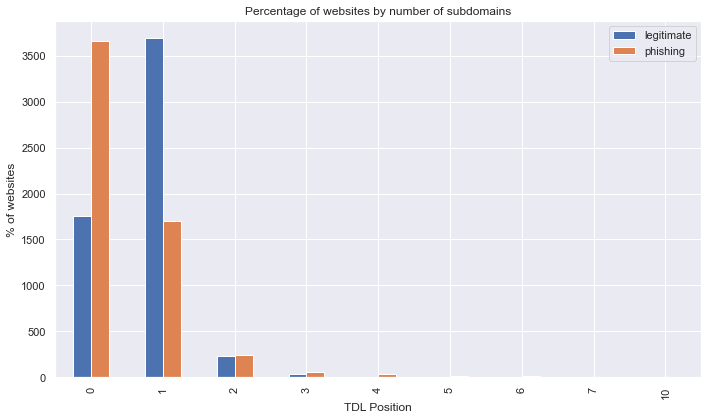

In [34]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(10,6)})
ax = ct_count_df.plot(kind='bar')
ax.set_xlabel("TDL Position")
ax.set_ylabel("% of websites")
ax.set_title("Percentage of websites by number of subdomains")
plt.tight_layout()
plt.show()

#### Description

Escrever descrição

### HTTPS Token | 25

In [35]:
contains_https_token = model_train[model_train['https_token'] == 0]
no_contains_https_token = model_train[model_train['https_token'] == 1]

In [36]:
contains_https_token_percentages = (contains_https_token['status'].value_counts(normalize=True) * 100).round().sort_index(ascending=False)
no_contains_https_token_percentages = (no_contains_https_token['status'].value_counts(normalize=True) * 100).round().sort_index(ascending=False)

In [37]:
df_contains_https_token = pd.DataFrame({'Status': contains_https_token_percentages.index, 'Percentage': contains_https_token_percentages.values})
df_no_contains_https_tokens = pd.DataFrame({'Status': no_contains_https_token_percentages.index, 'Percentage': no_contains_https_token_percentages.values})

In [38]:
df_contains_and_no = pd.concat([df_contains_https_token, df_no_contains_https_tokens], keys=['Contains HTTPS Token', 'No HTTPS Token'])

#### Table

In [39]:
df_contains_and_no

Status  Percentage
Contains HTTPS Token 0    phishing        43.0
                     1  legitimate        57.0
No HTTPS Token       0    phishing        55.0
                     1  legitimate        45.0

#### Graph

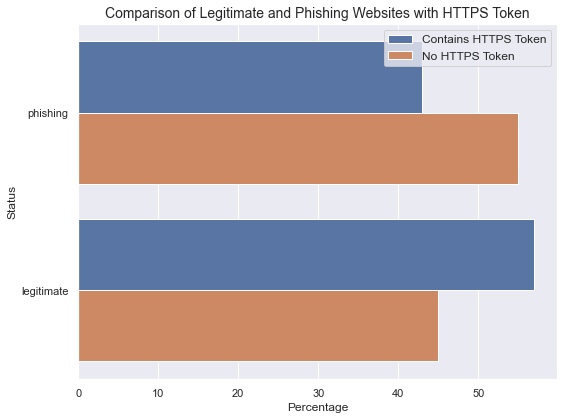

In [40]:
plt.figure(figsize=(8,6))
sns.barplot(x='Percentage', y='Status', hue='level_0', data=df_contains_and_no.reset_index())
plt.xlabel('Percentage', fontsize=12)
plt.ylabel('Status', fontsize=12)
plt.title('Comparison of Legitimate and Phishing Websites with HTTPS Token', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.tight_layout()
plt.show()

#### Description

The difference between 

### Ration of Digits | 26 -27

In [41]:
grouped_ratio = (model_train.groupby("status")[["ratio_digits_url", "ratio_digits_host"]].mean()) * 100

#### Table

In [42]:
grouped_ratio

,ratio_digits_url,ratio_digits_host
status,,
legitimate,2.12903,0.406681
phishing,8.49843,4.598061


#### Graph

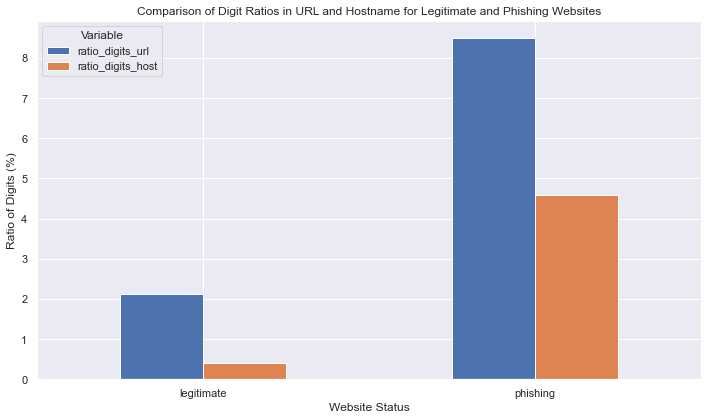

In [43]:
grouped_ratio.plot(kind="bar")
plt.xticks(rotation=0)
plt.title("Comparison of Digit Ratios in URL and Hostname for Legitimate and Phishing Websites")
plt.xlabel("Website Status")
plt.ylabel("Ratio of Digits (%)")
plt.legend(title="Variable", loc="upper left")
plt.tight_layout()
plt.show()

#### Description

high ration of digitis its a high indicator of a phishing website

### Punycode | 28

#### Table

#### Graph

#### Description

### Port | 29

#### Table

#### Graph

#### Description

### TLD position | 30 - 31

In [44]:
model_train['tld_amount'] = model_train['tld_in_path'] + model_train['tld_in_subdomain']

In [45]:
tld_unique = model_train["tld_amount"].unique()

In [46]:
tld_dict = {}
for value in tld_unique:
    tld_df = model_train[model_train["tld_amount"] == value]
    tld_dict[value] = {"legitimate": tld_df[tld_df["status"] == "legitimate"].shape[0],
                      "phishing": tld_df[tld_df["status"] == "phishing"].shape[0]}

In [47]:
tld_count_df = pd.DataFrame.from_dict(tld_dict, orient="index")
tld_count_df.index.name = "tld_amount"
tld_count_df = tld_count_df.sort_index()

#### Table

In [48]:
tld_count_df

,legitimate,phishing
tld_amount,,
0,5427,4795
1,287,806
2,1,114


#### Graph

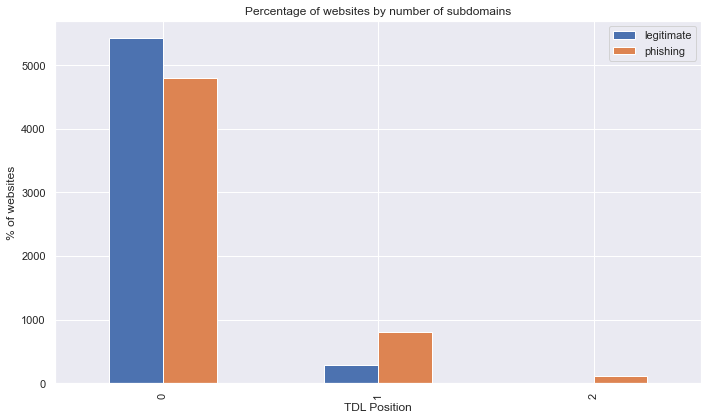

In [49]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(10,6)})
ax = tld_count_df.plot(kind='bar')
ax.set_xlabel("TDL Position")
ax.set_ylabel("% of websites")
ax.set_title("Percentage of websites by number of subdomains")
plt.tight_layout()
plt.show()

#### Description

### Abnormal Subdomains | 32

In [50]:
contains_ab_sub = model_train[model_train['abnormal_subdomain'] == 1]
no_contains_ab_sub = model_train[model_train['abnormal_subdomain'] == 0]

In [51]:
contains_ab_sub_percentages = (contains_ab_sub['status'].value_counts(normalize=True) * 100).round().sort_index(ascending=False)
no_contains_ab_sub_percentages = (no_contains_ab_sub['status'].value_counts(normalize=True) * 100).round().sort_index(ascending=False)

In [52]:
df_contains_https_token = pd.DataFrame({'Status': contains_ab_sub_percentages.index, 'Percentage': contains_ab_sub_percentages.values})
df_no_contains_ab_sub = pd.DataFrame({'Status': no_contains_ab_sub_percentages.index, 'Percentage': no_contains_ab_sub_percentages.values})

In [53]:
df_contains_and_no_ab = pd.concat([df_contains_https_token, df_no_contains_ab_sub], keys=['YES', 'NO'])

#### Table

In [54]:
df_contains_and_no_ab

Status  Percentage
YES 0    phishing        93.0
    1  legitimate         7.0
NO  0    phishing        49.0
    1  legitimate        51.0

#### Graph

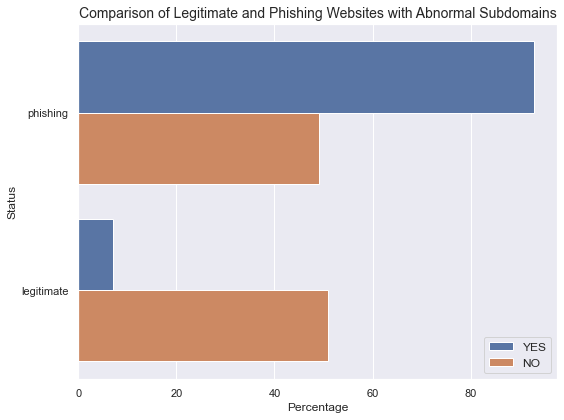

In [55]:
plt.figure(figsize=(8,6))
sns.barplot(x='Percentage', y='Status', hue='level_0', data=df_contains_and_no_ab.reset_index())
plt.xlabel('Percentage', fontsize=12)
plt.ylabel('Status', fontsize=12)
plt.title('Comparison of Legitimate and Phishing Websites with Abnormal Subdomains', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.tight_layout()
plt.show()

#### Description

### Number of Subdomains | 33

In [56]:
unique_subdomains = model_train['nb_subdomains'].unique()

In [57]:
# Create a new DataFrame to store the results
subdomains_df = pd.DataFrame(index=unique_subdomains, columns=['legitimate', 'phishing'])

In [58]:
# Calculate the average number of subdomains for each value of nb_subdomains
for subdomains in unique_subdomains:
    subdomains_legit = model_train[(model_train['nb_subdomains'] == subdomains) & (model_train['status'] == 'legitimate')].shape[0]
    subdomains_phish = model_train[(model_train['nb_subdomains'] == subdomains) & (model_train['status'] == 'phishing')].shape[0]
    subdomains_df.loc[subdomains] = [subdomains_legit, subdomains_phish]

In [59]:
subdomains_df = (subdomains_df.div(subdomains_df.sum(axis=1), axis=0) * 100).round().sort_index()

#### Table

In [60]:
subdomains_df

,legitimate,phishing
1,38.709677,61.290323
2,61.41146,38.58854
3,35.873418,64.126582


#### Graph

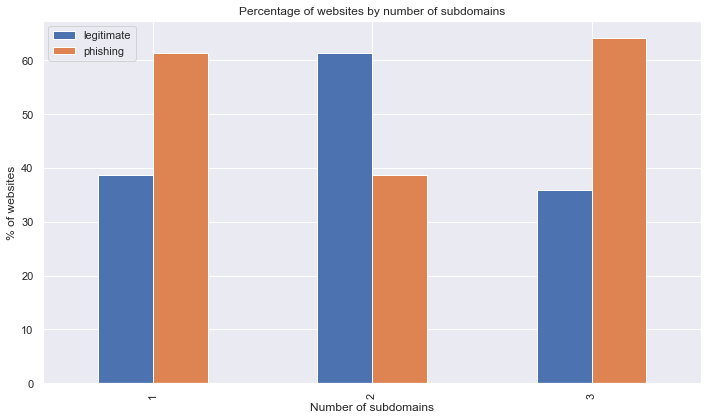

In [61]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(10,6)})
ax = subdomains_df.plot(kind='bar')
ax.set_xlabel("Number of subdomains")
ax.set_ylabel("% of websites")
ax.set_title("Percentage of websites by number of subdomains")
plt.tight_layout()
plt.show()

#### Description

### Prefix Suffix | 34

In [62]:
contains_prefix = model_train[model_train['prefix_suffix'] == 1]
no_contains_prefix = model_train[model_train['prefix_suffix'] == 0]

In [63]:
contains_prefix_percentages = (contains_prefix['status'].value_counts(normalize=True) * 100).round().sort_index(ascending=False)
no_contains_prefix_percentages = (no_contains_prefix['status'].value_counts(normalize=True) * 100).round().sort_index(ascending=False)

In [64]:
df_contains_prefix = pd.DataFrame({'Status': contains_prefix_percentages.index, 'Percentage': contains_prefix_percentages.values})
df_no_contains_prefix = pd.DataFrame({'Status': no_contains_prefix_percentages.index, 'Percentage': no_contains_prefix_percentages.values})

In [65]:
df_contains_and_no_prefix = pd.concat([df_contains_prefix, df_no_contains_prefix], keys=['YES', 'NO'])

#### Table

In [66]:
df_contains_and_no_prefix

Status  Percentage
YES 0    phishing        71.0
    1  legitimate        29.0
NO  0    phishing        45.0
    1  legitimate        55.0

#### Graph

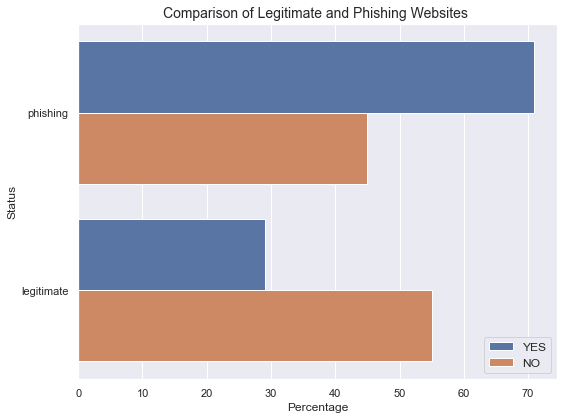

In [67]:
plt.figure(figsize=(8,6))
sns.barplot(x='Percentage', y='Status', hue='level_0', data=df_contains_and_no_prefix.reset_index())
plt.xlabel('Percentage', fontsize=12)
plt.ylabel('Status', fontsize=12)
plt.title('Comparison of Legitimate and Phishing Websites ', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.tight_layout()
plt.show()

# corregir grafico 

#### Description

### Random domains

In [68]:
contains_random = model_train[model_train['random_domain'] == 1]
no_contains_random = model_train[model_train['random_domain'] == 0]

In [69]:
contains_random_percentages = (contains_random['status'].value_counts(normalize=True) * 100).round().sort_index(ascending=False)
no_contains_random_percentages = (no_contains_random['status'].value_counts(normalize=True) * 100).round().sort_index(ascending=False)

In [70]:
df_contains_random = pd.DataFrame({'Status': contains_random_percentages.index, 'Percentage': contains_random_percentages.values})
df_no_contains_random = pd.DataFrame({'Status': no_contains_random_percentages.index, 'Percentage': no_contains_random_percentages.values})

In [71]:
df_contains_and_no_prefix = pd.concat([df_contains_random, df_no_contains_random], keys=['Contains Prefix and Sufix', 'Dont Contains Prefix and Sufix'])

#### Table

In [72]:
df_contains_and_no_prefix

Status  Percentage
Contains Prefix and Sufix      0    phishing        53.0
                               1  legitimate        47.0
Dont Contains Prefix and Sufix 0    phishing        50.0
                               1  legitimate        50.0

#### Graph

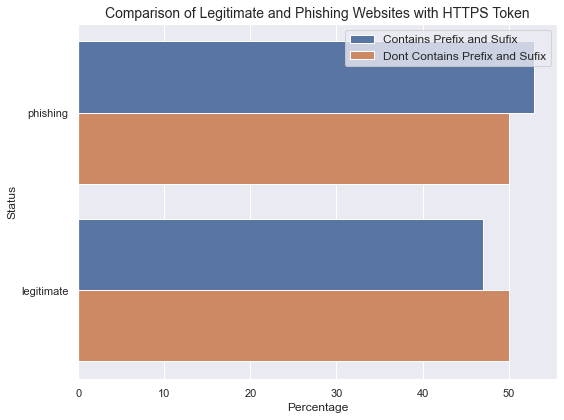

In [73]:
plt.figure(figsize=(8,6))
sns.barplot(x='Percentage', y='Status', hue='level_0', data=df_contains_and_no_prefix.reset_index())
plt.xlabel('Percentage', fontsize=12)
plt.ylabel('Status', fontsize=12)
plt.title('Comparison of Legitimate and Phishing Websites with HTTPS Token', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.tight_layout()
plt.show()

# corrigir grafico

### 

#### Description

## 

### Encoding

In [74]:
lb = LabelBinarizer()

In [75]:
# Transform status column to binary labels
model_train['status'] = lb.fit_transform(model_train['status'])

### Select Numerical Features

In [76]:
numerical_features = model_train.select_dtypes(include=np.number).columns.tolist()

In [77]:
numerical_features.pop(-4)

'status'

### Scale

In [78]:
# Create a StandardScaler object
scaler = StandardScaler()
scaler.fit(model_train[numerical_features])
scaled_features = scaler.transform(model_train[numerical_features])

In [79]:
scaled_features

array([[-0.43632748, -0.19396372, -0.42102044, ..., -0.49100723,
         0.58692647, -0.33074524],
       [ 0.28706655,  0.17720743,  2.37518157, ..., -0.49100723,
        -0.87942754, -0.33074524],
       [ 1.17322424,  2.6826127 ,  2.37518157, ...,  1.49228199,
         0.58692647,  2.5267136 ],
       ...,
       [ 0.79344237, -0.47234208,  2.37518157, ...,  1.16173379,
         0.58692647, -0.33074524],
       [-0.41824263,  0.82675695, -0.42102044, ..., -0.65628134,
         0.58692647, -0.33074524],
       [ 7.52100688, -0.65792766,  2.37518157, ..., 14.71421017,
         6.45234251,  5.38417243]])

In [80]:
model_train[numerical_features] = scaled_features

### ANOVA

In [81]:
X = model_train.drop(['url', 'status'], axis=1)
y = model_train['status']

In [82]:
# Perform ANOVA on the features
f_values, p_values = f_classif(X, y)

C:\Users\pedro\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 8 59 61 63 68 71] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\pedro\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [83]:
f_p_df = pd.DataFrame({'feature': X.columns, 'F_value': f_values, 'p_value': p_values})

### Correlation

In [84]:
corr_matrix = model_train.corr()

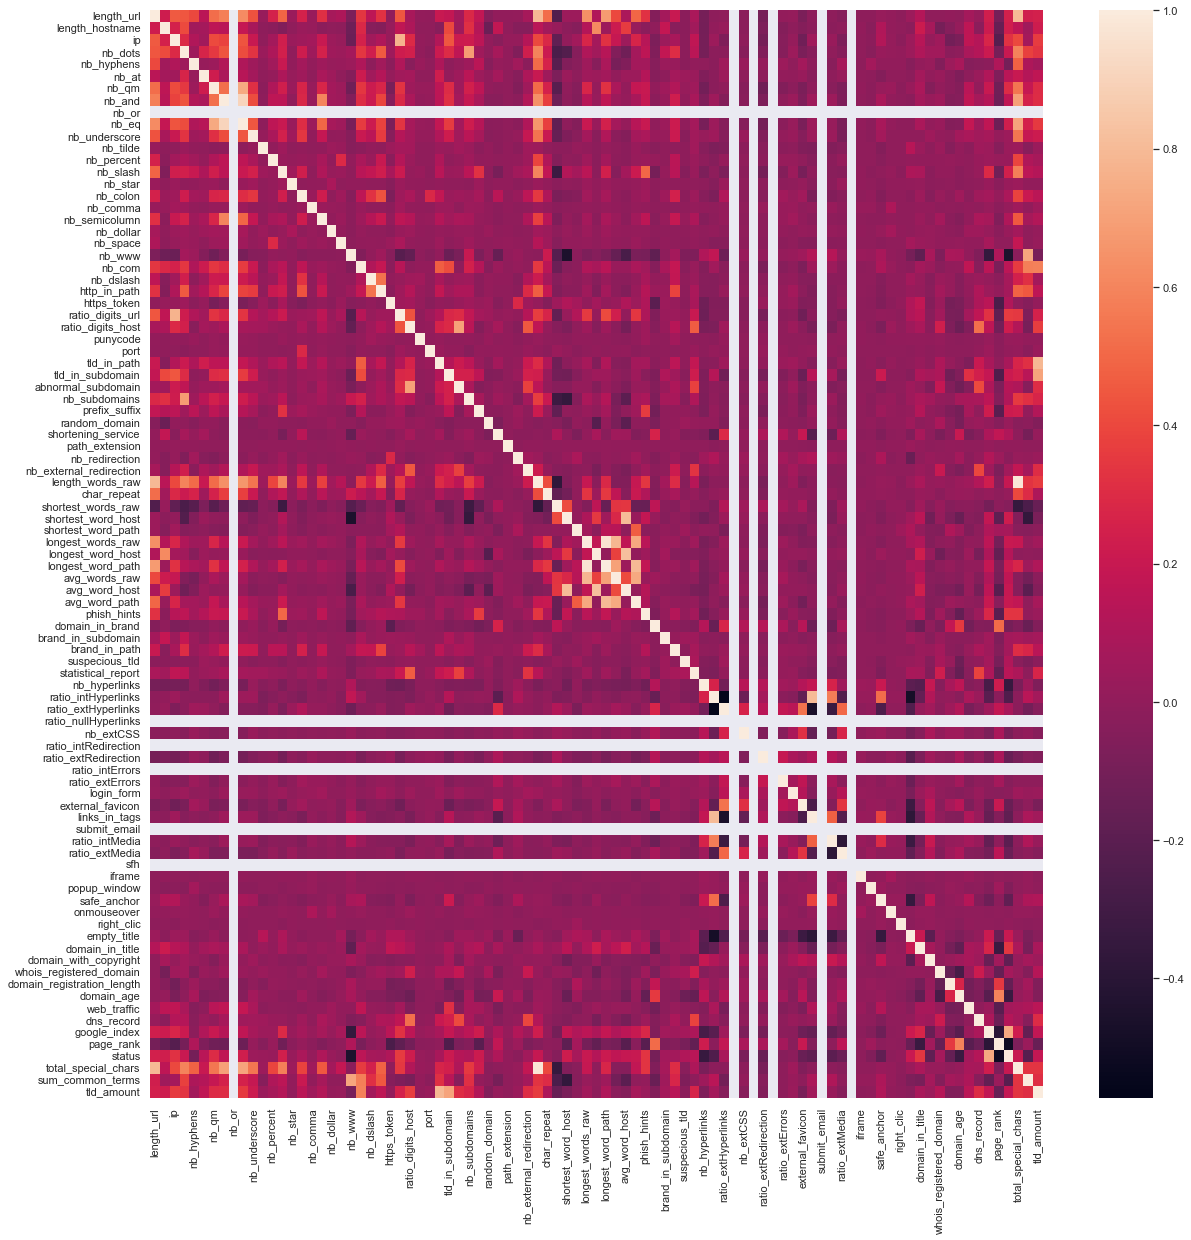

In [85]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(20,20))

# Create heatmap
sns.heatmap(corr_matrix, annot=False, ax=ax)

# Rotate x-axis labels for readability
plt.xticks(rotation=90)

# Show plot
plt.show()

### Split into Train and Test

In [86]:
X = model_train.drop(['url', 'status'], axis=1)
y = model_train['status']

In [87]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=3, shuffle=True)

### MODEL CLASS

In [88]:
class ModelTester:
    def __init__(self, X_train, y_train, cv=KFold(n_splits=5, shuffle=True, random_state=3)):
        self.X_train = X_train
        self.y_train = y_train
        self.cv = cv

    def test_models(self):
        models = {
            'SVM': SVC(),
            'Gaussian Naive Bayes': GaussianNB(),
            'Decision Tree': DecisionTreeClassifier(),
            'K-Nearest Neighbors': KNeighborsClassifier(),
            'Random Forest': RandomForestClassifier(),
            'Logistic Regression': LogisticRegression(),
            'Gradient Boosting': GradientBoostingClassifier(),
            'XGBoost': XGBClassifier()
        }
        
        for model_name, model in models.items():
            pipe = Pipeline([
                ('scaler', StandardScaler()),
                ('model', model)
            ])
            
            param_grid = {}
            
            if model_name == 'SVM':
                param_grid = {
                    'model__C': [0.1, 1, 10],
                    'model__kernel': ['linear', 'rbf', 'poly'],
                    'model__degree': [2, 3, 4],
                    'model__gamma': ['scale', 'auto']
                }
            elif model_name == 'Decision Tree':
                param_grid = {
                    'model__criterion': ['gini', 'entropy'],
                    'model__max_depth': [2, 4, 6, 8, 10, 12],
                    'model__min_samples_split': [2, 5, 10],
                    'model__min_samples_leaf': [1, 2, 4]
                }
            elif model_name == 'K-Nearest Neighbors':
                param_grid = {
                    'model__n_neighbors': [3, 5, 7, 9],
                    'model__weights': ['uniform', 'distance'],
                    'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
                }
            elif model_name == 'Random Forest':
                param_grid = {
                    'model__n_estimators': [50, 100, 200],
                    'model__criterion': ['gini', 'entropy'],
                    'model__max_depth': [2, 4, 6, 8, 10, 12],
                    'model__min_samples_split': [2, 5, 10],
                    'model__min_samples_leaf': [1, 2, 4],
                    'model__bootstrap': [True, False]
                }
            elif model_name == 'Logistic Regression':
                param_grid = {
                    'model__C': [0.1, 1, 10],
                    'model__penalty': ['l1', 'l2'],
                    'model__solver': ['liblinear']
                }
            elif model_name == 'Gradient Boosting':
                param_grid = {
                    'model__learning_rate': [0.1, 0.05, 0.01],
                    'model__n_estimators': [50, 100, 200],
                    'model__max_depth': [2, 4, 6, 8, 10],
                    'model__min_samples_split': [2, 5, 10],
                    'model__min_samples_leaf': [1, 2, 4]
                }
            elif model_name == 'XGBoost':
                param_grid = {
                    'model__learning_rate': [0.1, 0.05, 0.01],
                    'model__n_estimators': [50, 100, 200],
                    'model__max_depth': [2, 4, 6, 8, 10],
                    'model__min_child_weight': [1, 3, 5],
                    'model__gamma': [0.0, 0.1, 0.2],
                    'model__subsample': [0.6, 0.8, 1.0],
                    'model__colsample_bytree': [0.6, 0.8, 1.0],
                    'model__reg_alpha': [0, 0.001, 0.005, 0.01, 0.05]
                }
            else:
                param_grid = {}
        
            search = GridSearchCV(pipe, param_grid, cv=self.cv, scoring='accuracy', n_jobs=-1)
            search.fit(self.X_train, self.y_train)

            print(f"Best parameters for {model_name}:")
            print(search.best_params_)
            print(f"Best cross-validation score for {model_name}:")
            print(search.best_score_)
            print('\n')

In [89]:
# create an instance of the ModelTester class
model_tester = ModelTester(X_train, y_train)

# test all the models and store the best scores in a dictionary
best_scores = {}
for model_name, _ in model_tester.test_models().items():
    pipe = model_tester.create_pipeline(model_name)
    search = model_tester.run_grid_search(pipe, model_name)
    best_scores[model_name] = search.best_score_

# print out the best scores for each model
for model_name, best_score in best_scores.items():
    print(f"Best cross-validation score for {model_name}: {best_score:.4f}")

KeyboardInterrupt: 